# Objectives

1. Plot Spread Map of Branch Number
1. Objective 2

---
# Setup

## Imports

In [1]:
import os
import dill
from Bio import Phylo
import copy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, transform

## Variables

In [2]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "geo"
PREV_DIR = "locus_coverage/all"
PREV_NAME = "locus_coverage"

GEO_ATTR = "Mugration_Province"
PLOT_ATTR = "Mugration_Branch_Number"
COL_ATTR = "Mugration_Branch_Major"

## File Paths

In [3]:
# jupyter notebook output
aln_path     = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
tree_df_dill = "../../results/{}/{}.df.obj".format(PREV_DIR, PREV_NAME)
tree_dill    = "../../results/{}/{}_timetree.treetime.obj".format(PREV_DIR, PREV_NAME)

# Auspice
auspice_latlon_path     = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path     = "../../results/parse_tree/parse_tree_colors.tsv"
auspice_config_path     = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"

# Output
outdir = "../../results/{}/".format(SCRIPT_NAME)

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Import Tree

In [26]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [27]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
display(tree_df)

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,Chrom_cov,pCD1_cov,pMT1_cov,pPCP1_cov,pla_cov,Chrom_dep,pCD1_dep,pMT1_dep,pPCP1_dep,pla_dep,pPCP1_pla_dep_ratio
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08,0.PRE,0.998731,0.00977069,0.PRE2,0.392436,1.32907,Russia,0.99242,0.0484304,64.6863,97.7453,Krasnoyarsk Krai,0.382138,1.65207,63.3234,97.098,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12,0.PRE,1,-9.99867e-13,0.PRE2,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Krasnoyarsk Krai,1,-1.00009e-12,63.3234,97.098,0.945769,0.926392,0.725216,0.797233,1,19.494,32.7473,11.4042,20.5553,19.8166,1.03728
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08,0.PRE,0.999998,2.33079e-05,0.PRE1,0.999213,0.00727438,Russia,0.977706,0.136133,64.6863,97.7453,Panevezys County,0.442487,1.9261,55.9156,25.0312,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12,0.PRE,1,-1.00009e-12,0.PRE1,1,-1.00009e-12,Lithuania,1,-1.00009e-12,55.35,23.75,Panevezys County,1,-1.00009e-12,55.9156,25.0312,0.939948,0.933461,0.725195,0.803059,1,5.03738,9.93292,4.67118,19.5298,23.4222,0.833815
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08,0.PRE,1,2.10548e-07,0.PRE1,0.999999,1.69062e-05,Russia,0.97708,0.14249,64.6863,97.7453,Pärnu maakond,0.442563,1.92163,58.3195,24.3026,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [28]:
# Remove Bad Samples

# CDC : GCA_002529545.1_ASM252954v1_genomic
# Drop CDC Sample: GCA_002529545.1_ASM252954v1_genomic
node = tt.tree.common_ancestor("GCA_002529545.1_ASM252954v1_genomic")
parent = node.up
tt.tree.prune(node)
tree_df.drop(node.name, inplace=True)
tree_df.drop(parent.name, inplace=True)

## Convert Dataframe to Geopandas

In [29]:
#df = tree_df[tree_df[GEO_ATTR + "_Lon"] != NO_DATA_CHAR]

geometry = [shapely.geometry.Point(xy) for xy in zip(tree_df[GEO_ATTR + "_Lon"], tree_df[GEO_ATTR + "_Lat"])]
#df.drop([GEO_ATTR + "_Lon", GEO_ATTR + "_Lat"], axis=1, inplace=True)
#WGS84 = "epsg:4326"
tree_gdf = geopandas.GeoDataFrame(tree_df, crs=CRS, geometry=geometry)
display(tree_gdf)

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,Chrom_cov,pCD1_cov,pMT1_cov,pPCP1_cov,pla_cov,Chrom_dep,pCD1_dep,pMT1_dep,pPCP1_dep,pla_dep,pPCP1_pla_dep_ratio,geometry
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08,0.PRE,0.998731,0.00977069,0.PRE2,0.392436,1.32907,Russia,0.99242,0.0484304,64.6863,97.7453,Krasnoyarsk Krai,0.382138,1.65207,63.3234,97.098,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (97.09800 63.32338)
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12,0.PRE,1,-9.99867e-13,0.PRE2,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Krasnoyarsk Krai,1,-1.00009e-12,63.3234,97.098,0.945769,0.926392,0.725216,0.797233,1,19.494,32.7473,11.4042,20.5553,19.8166,1.03728,POINT (97.09800 63.32338)
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08,0.PRE,0.999998,2.33079e-05,0.PRE1,0.999213,0.00727438,Russia,0.977706,0.136133,64.6863,97.7453,Panevezys County,0.442487,1.9261,55.9156,25.0312,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (25.03116 55.91560)
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12,0.PRE,1,-1.00009e-12,0.PRE1,1,-1.00009e-12,Lithuania,1,-1.00009e-12,55.35,23.75,Panevezys County,1,-1.00009e-12,55.9156,25.0312,0.939948,0.933461,0.725195,0.803059,1,5.03738,9.93292,4.67118,19.5298,23.4222,0.833815,POINT (25.03116 55.91560)
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08,0.PRE,1,2.10548e-07,0.PRE1,0.999999,1.69062e-05,Russia,0.97708,0.14249,64.6863,97.7453,Pärnu maakond,0.442563,1.92163,58.3195,24.3026,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (24.30261 58.31951)
...,...,...,...,.

# Import Colors

In [30]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

,Attribute,State,Color
0,branch_number,0,#8000ff
1,branch_number,3,#00b4ec
2,branch_number,4,#80ffb4
3,branch_number,2,#ffb462
4,branch_number,1,#ff0000
...,...,...,...
202,province,Midlands,#ff1c0e
203,province,State of Mato Grosso,#ff150b
204,province,MSila,#ff0e07
205,province,La Paz,#ff0704


---
# 1. Plot Nodes by Branch Number

## Calculate Size by Location

In [31]:
tip_gdf = tree_gdf[tree_gdf["Branch_Support_Color"] == TERM_COL]

# Sizes
marker_scale = 2
geom_sizes = {}
tt_copy = copy.deepcopy(tt)
for t in tt_copy.tree.get_terminals():
    geometry = str(tree_gdf["geometry"][t.name])
    if geometry not in geom_sizes:
        geom_sizes[geometry] = 1
    else:
        geom_sizes[geometry] += 1

## Tree

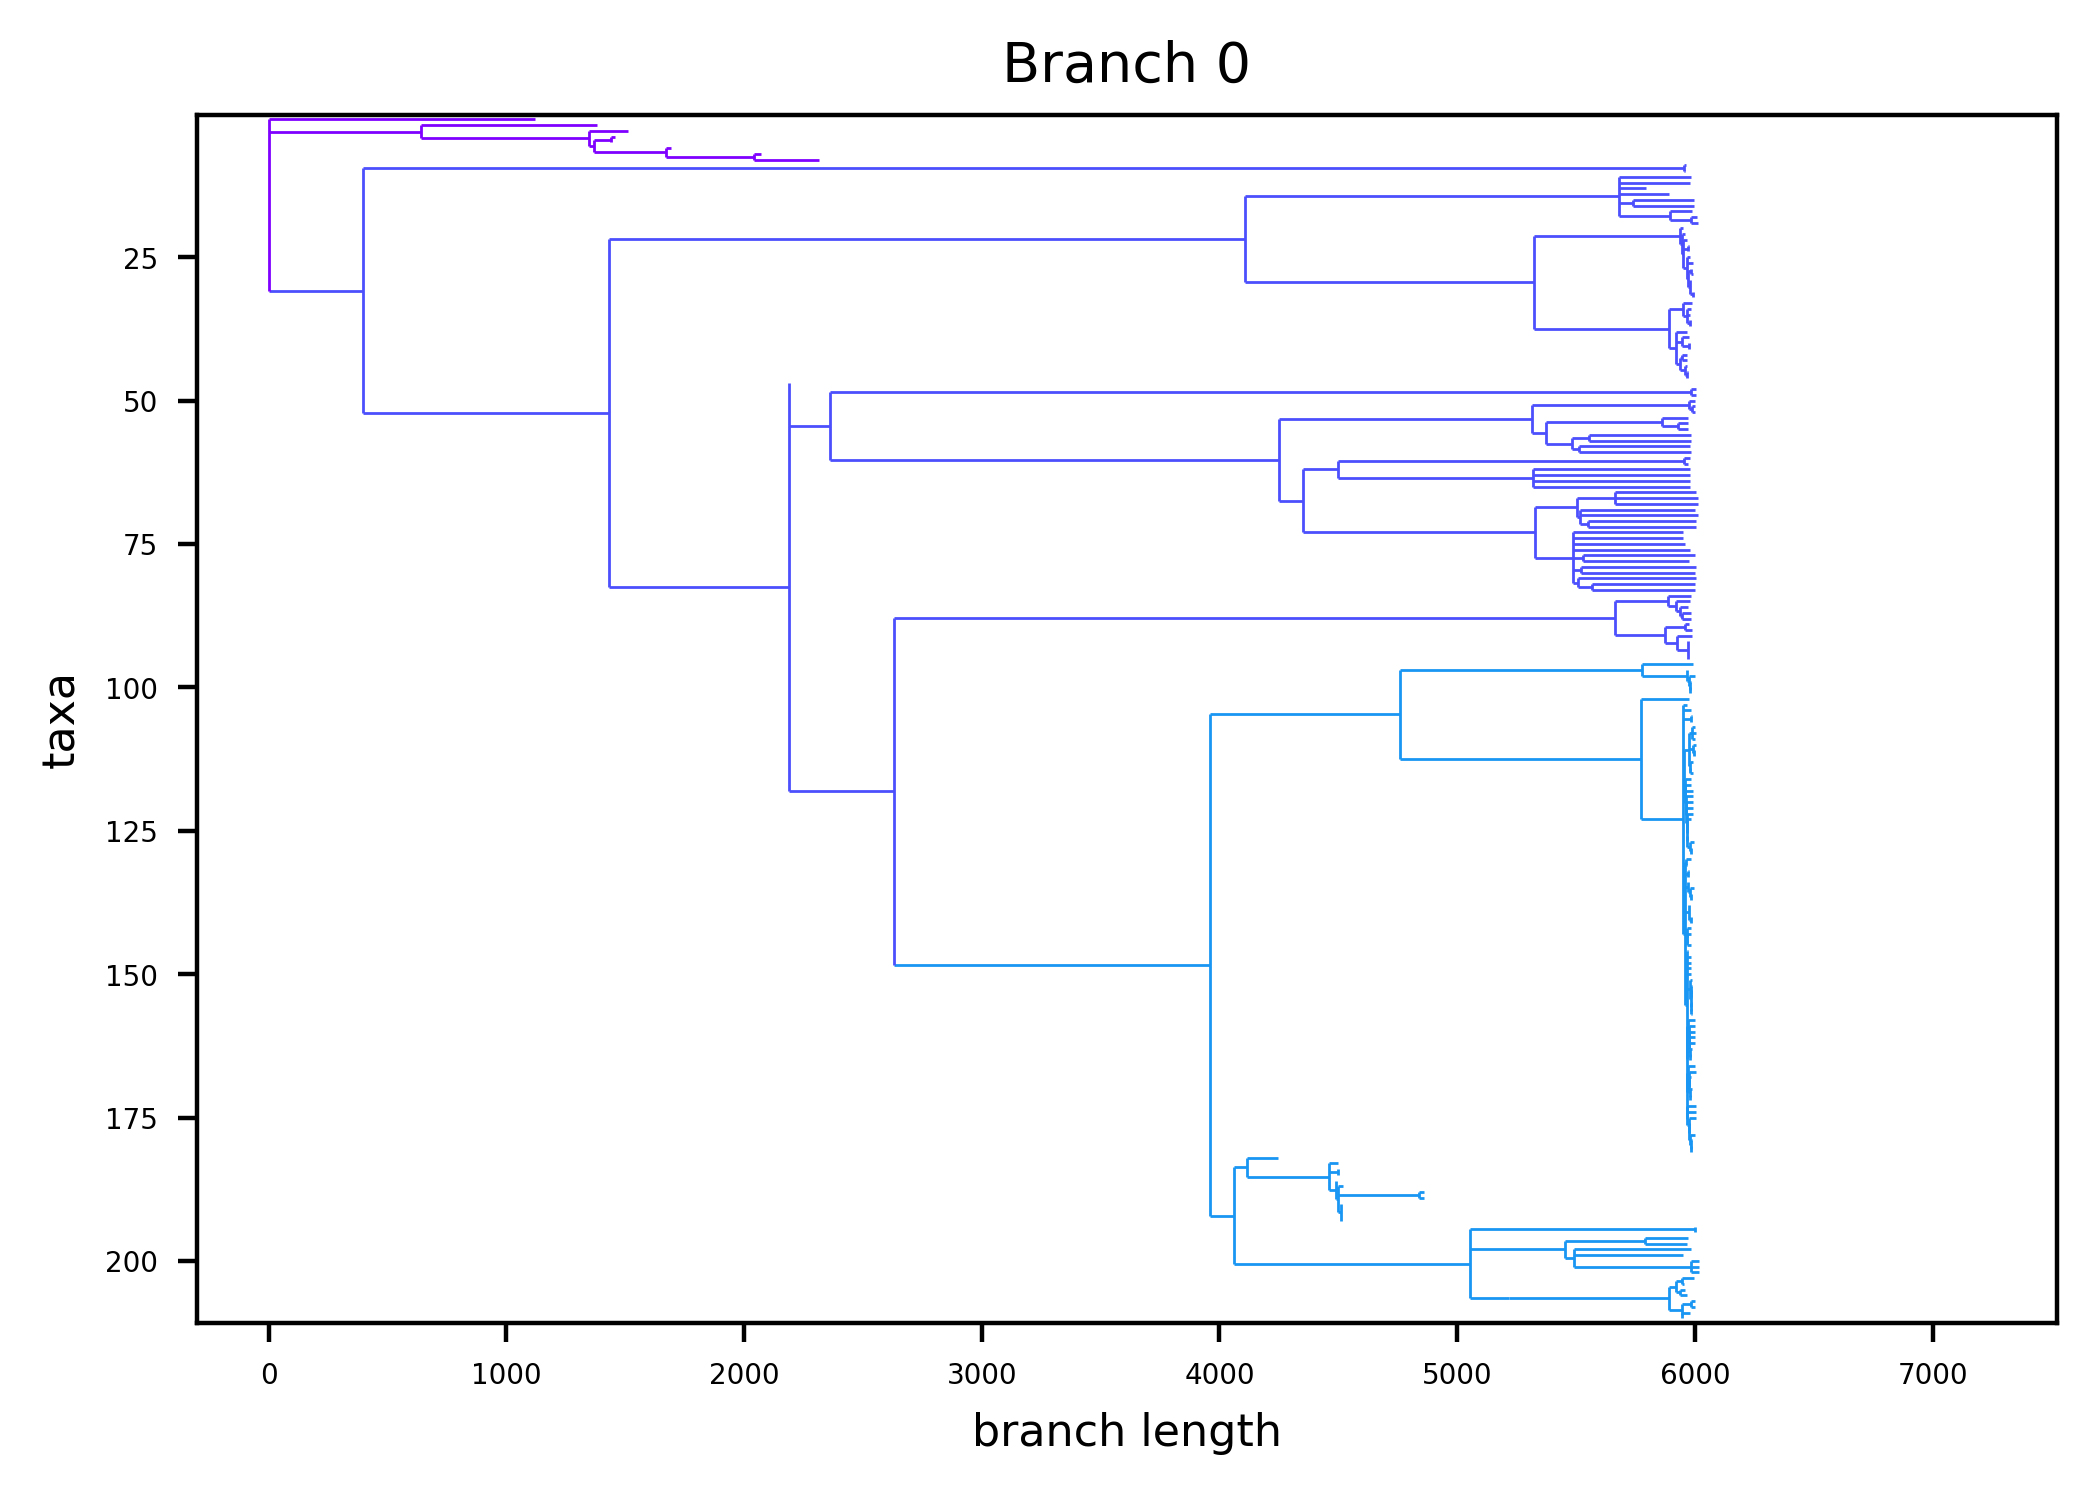

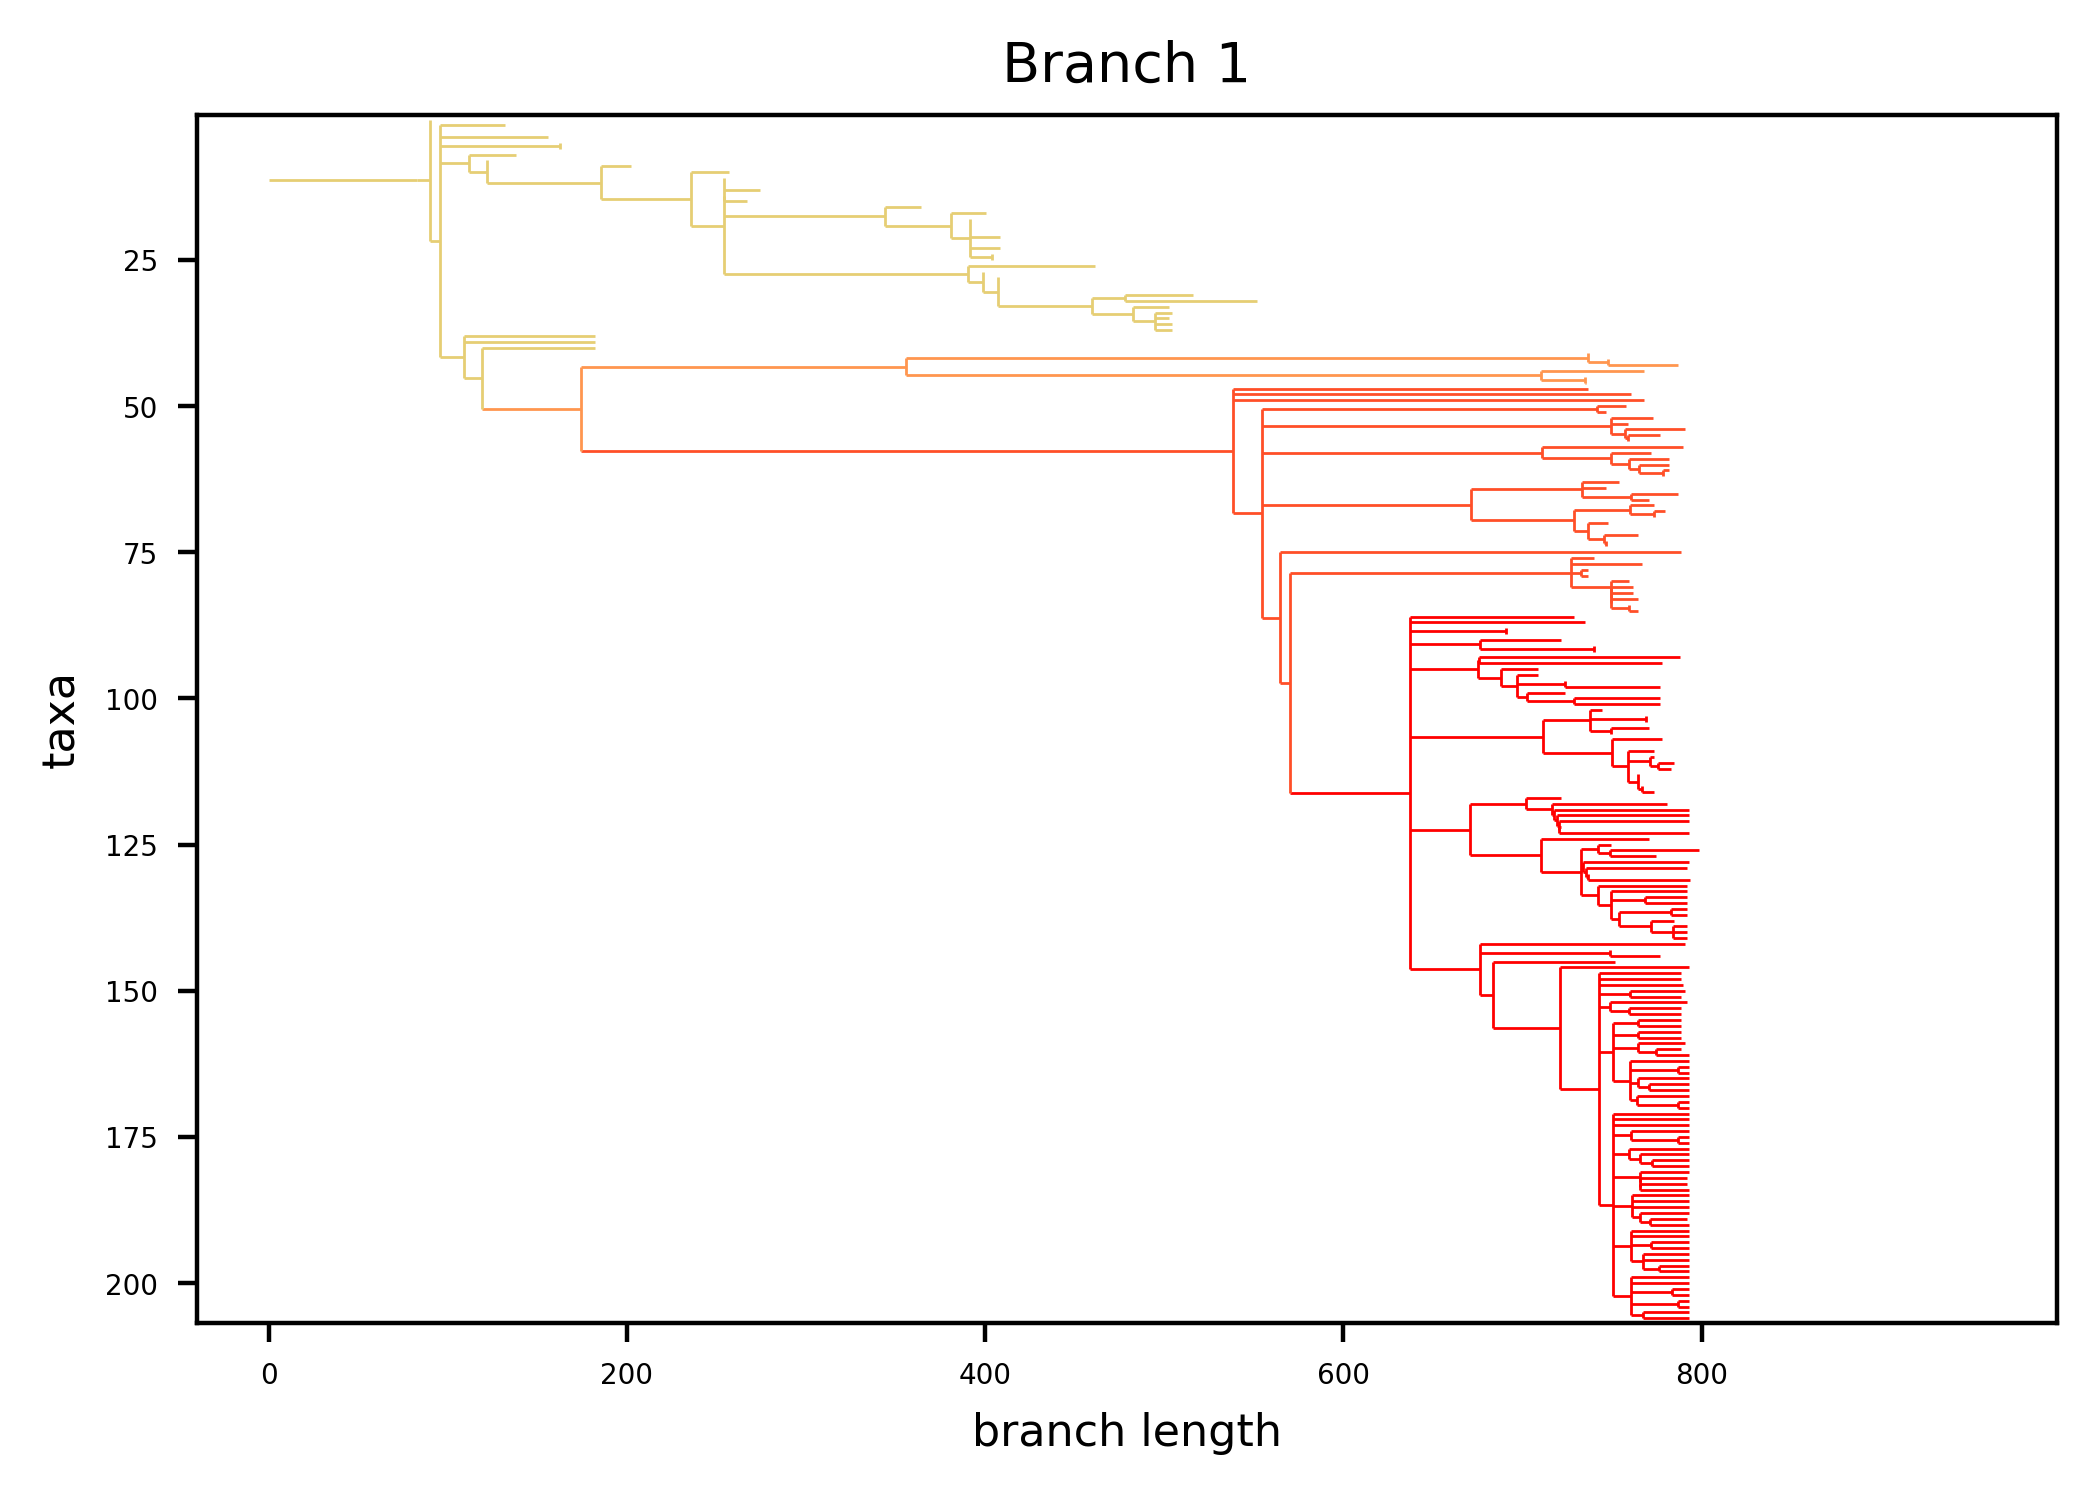

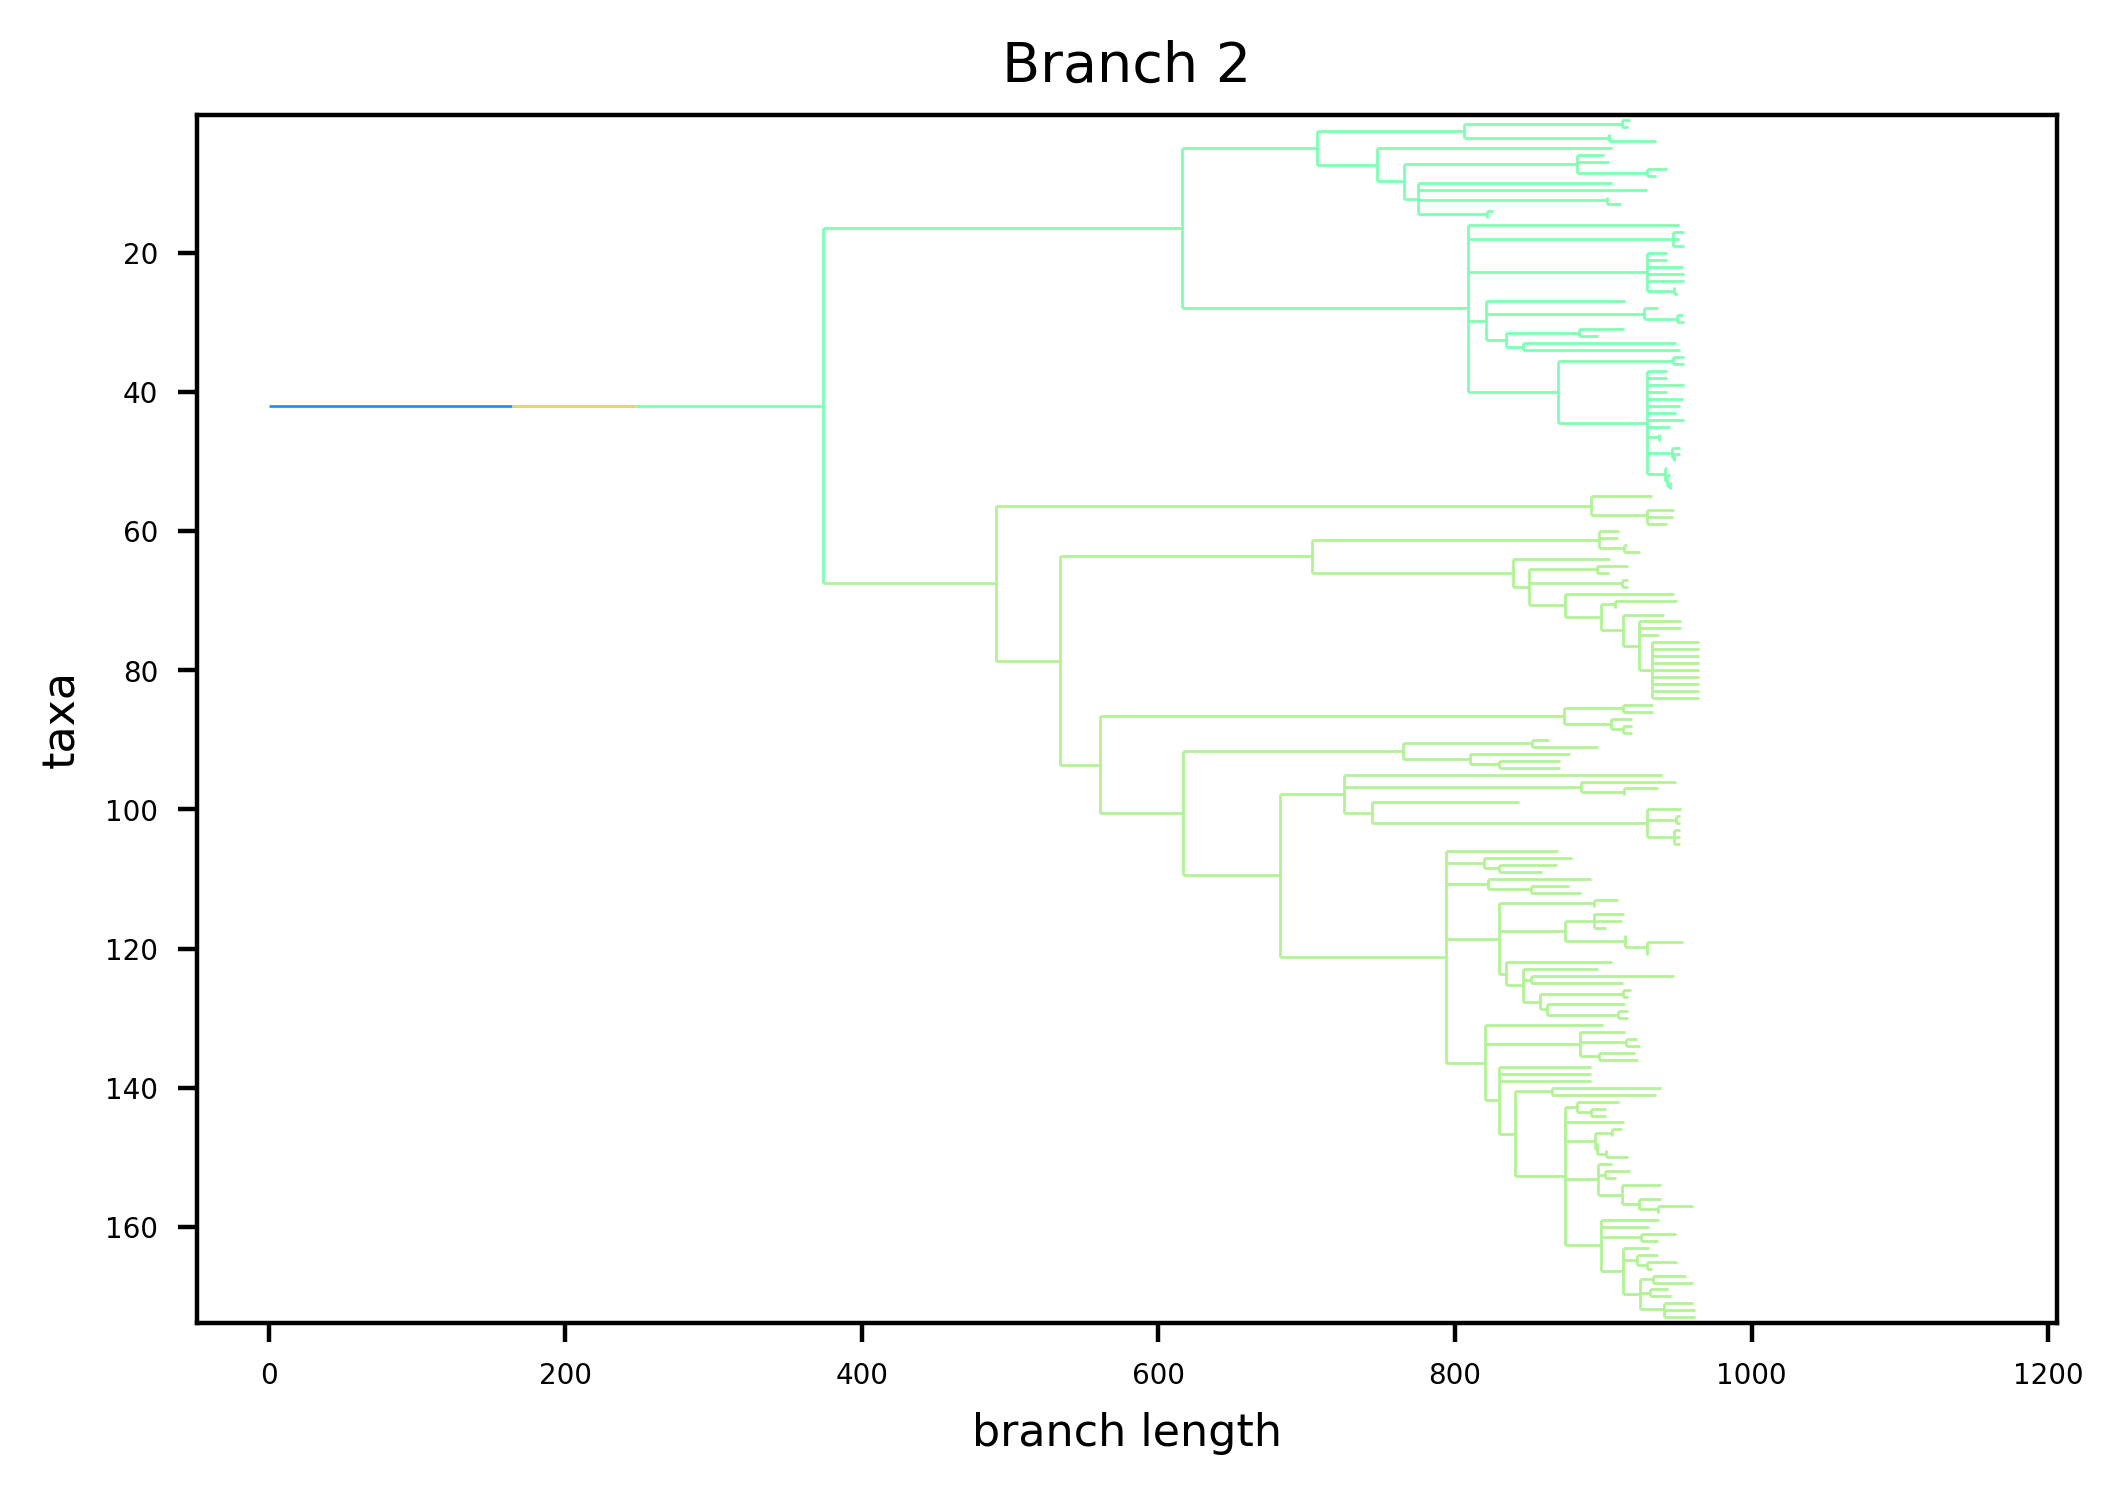

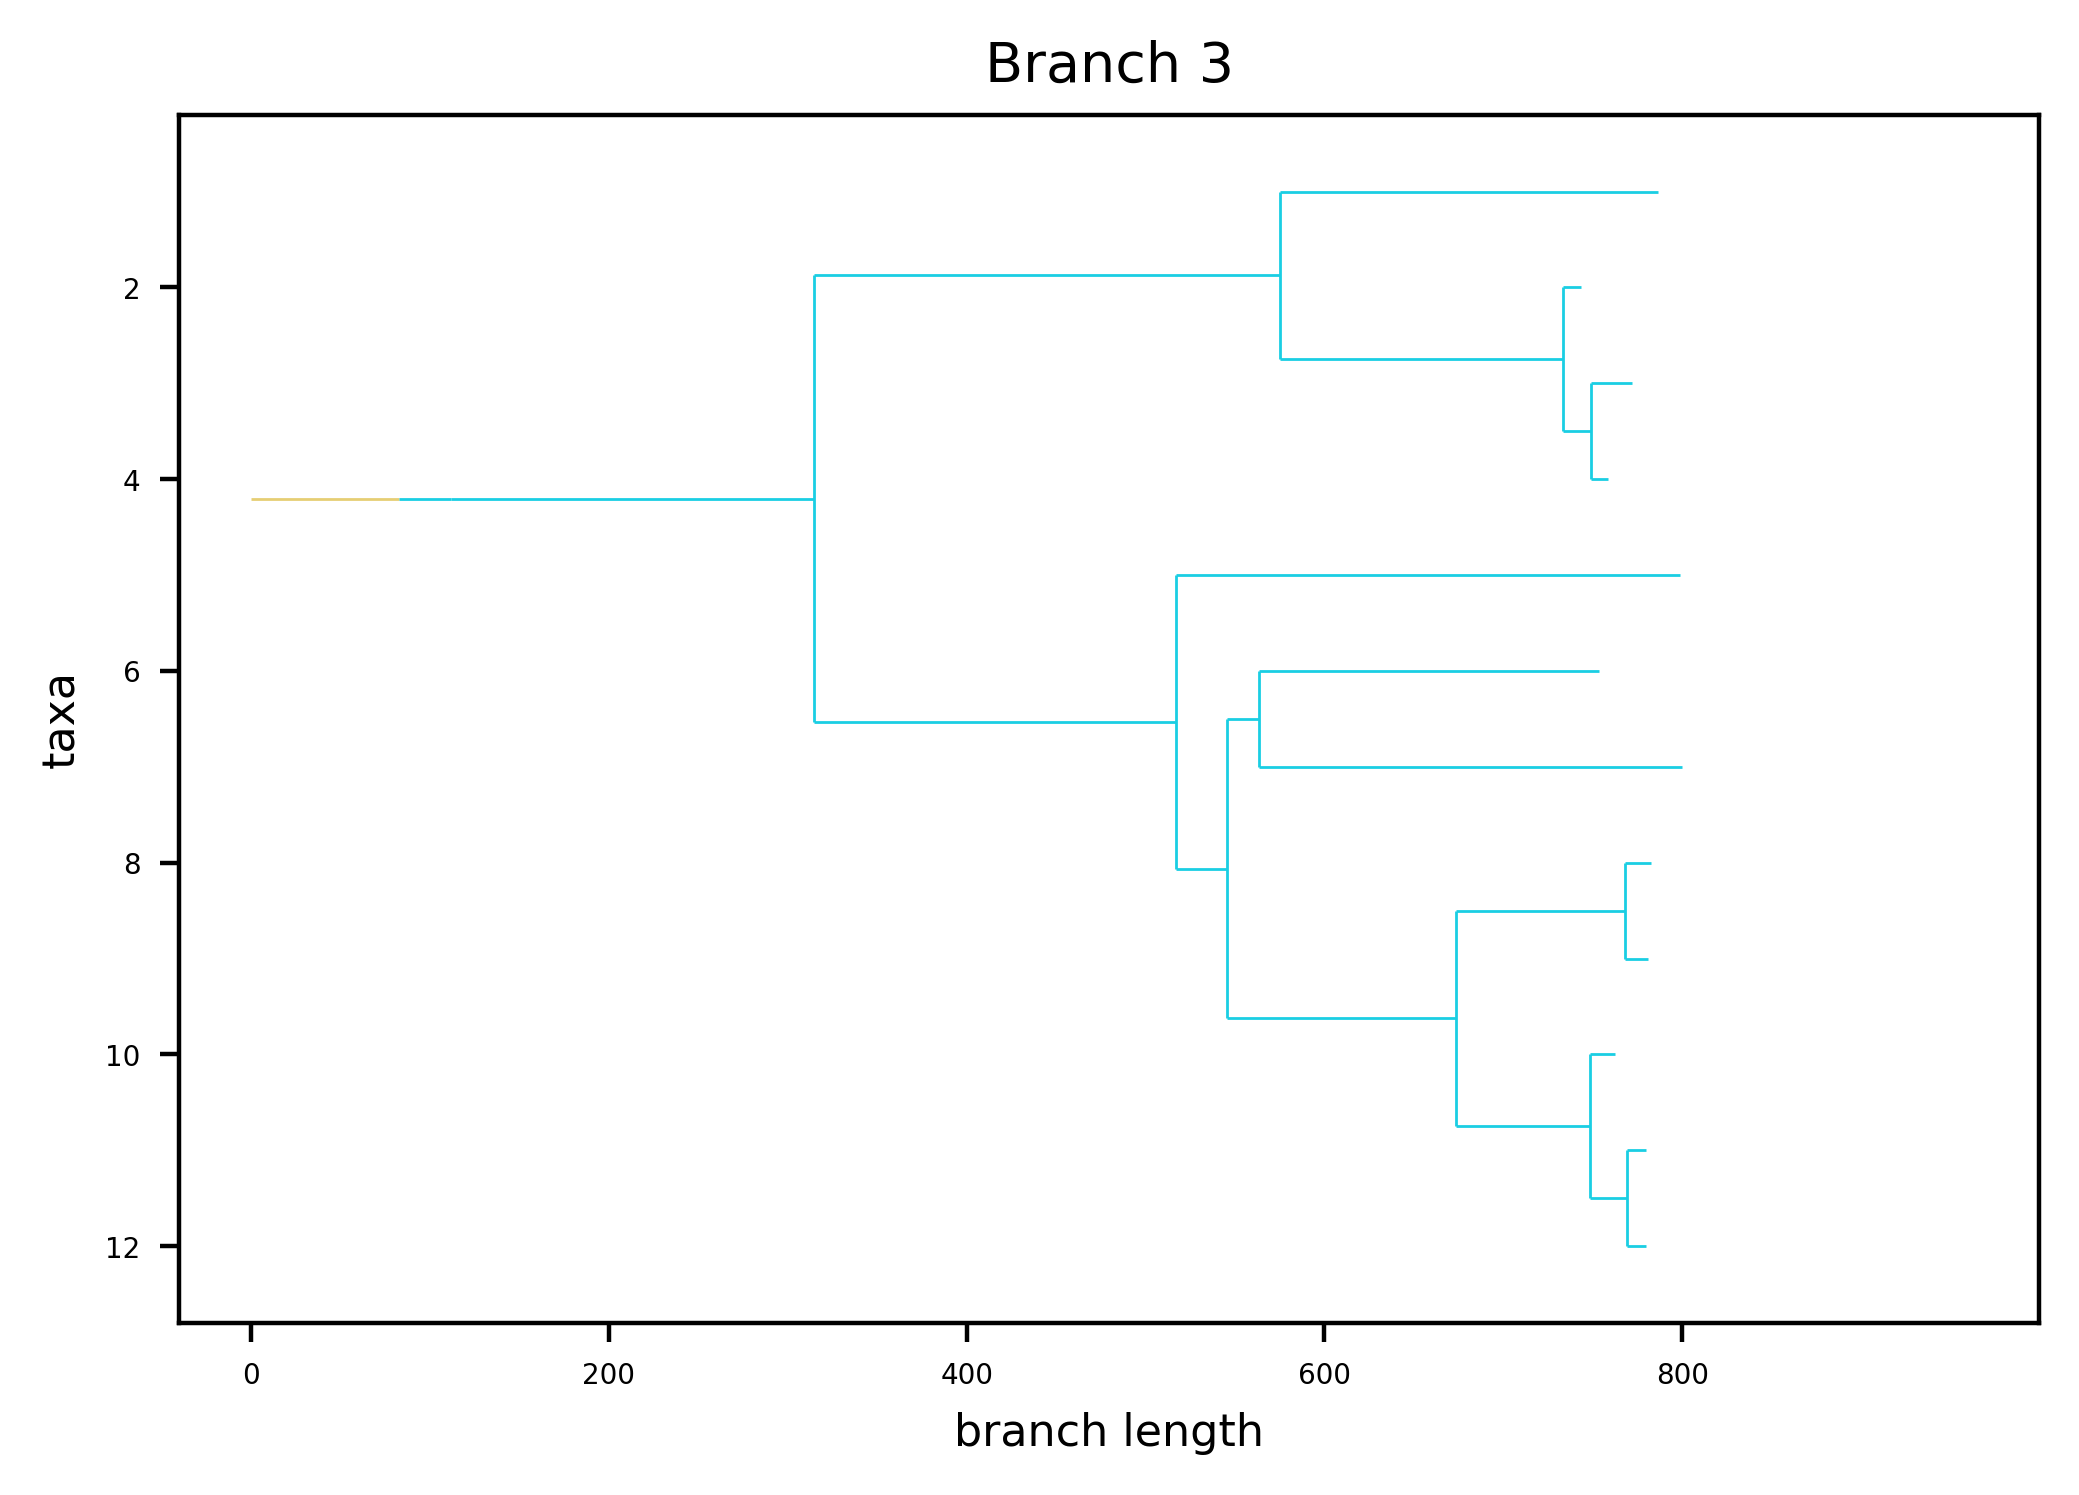

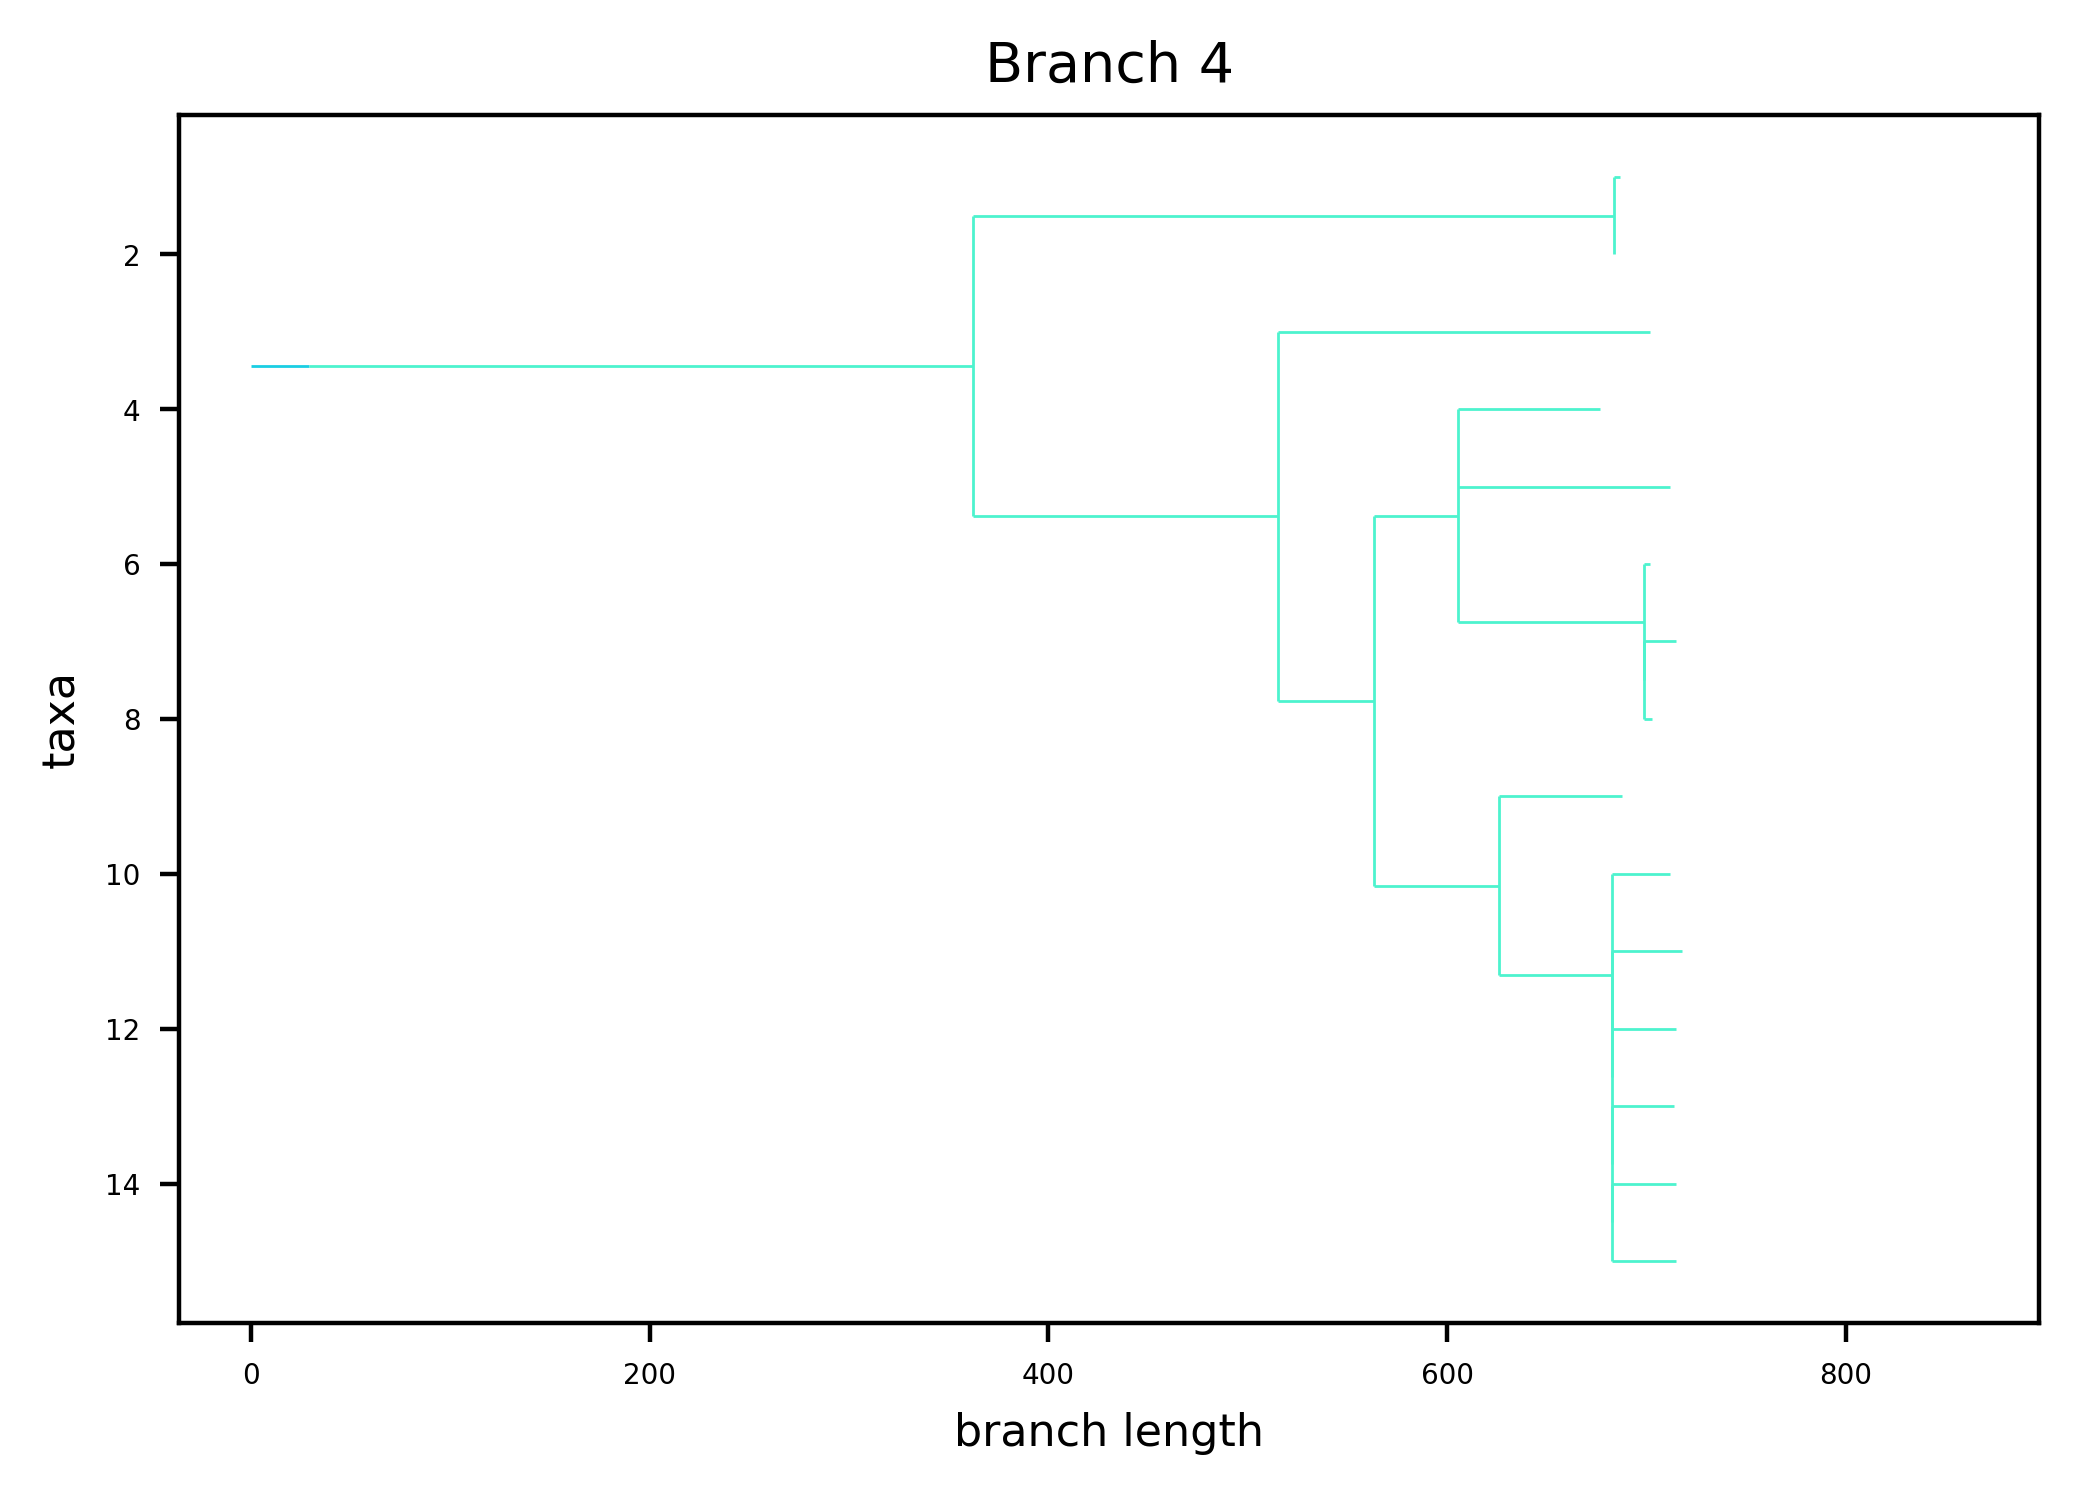

In [212]:
tt_copy = copy.deepcopy(tt)
branch_dict = {
    "0" : {
        "clade" : None,
        "gdf" : None,
    },
    "1" : {
        "clade" : None,
        "gdf" : None,
    },
    "2" : {
        "clade" : None,
        "gdf" : None,
    },
    "3" : {
        "clade" : None,
        "gdf" : None,
    },
    "4" : {
        "clade" : None,
        "gdf" : None,
    },    
}

for branch in branch_dict:
    target_gdf = copy.deepcopy(tree_gdf)    
    target_nodes = tree_gdf[tree_gdf["Mugration_Branch_Number"] == branch]
    # Add one level up to target nodes    
    target_mrca = tt_copy.tree.common_ancestor(target_nodes.index).up
    # If there's actually an upper node
    if target_mrca:
        mrca_rec = target_gdf[target_gdf.index.str.contains(target_mrca.name)]
        target_nodes = target_nodes.append(mrca_rec)
    # else reset to lower
    else:
        target_mrca = tt_copy.tree.common_ancestor(target_nodes.index)
    target_clade = copy.deepcopy(target_mrca)

    # Create a filtered df
    for rec in tree_df.iterrows():
        sample = rec[0]
        if sample not in target_nodes.index:
            target_gdf.drop(sample, inplace=True)
    branch_dict[branch]["gdf"] = target_gdf

    # Search for the nodes, finding tips to prune
    for c in target_mrca.find_clades(order="postorder"):
        cur_term = [t.name for t in target_clade.get_terminals()]    
        if c.name not in target_nodes.index:
            if c.name in cur_term:
                target_clade.collapse(target=c.name)
                
    # Color branches
    for c in target_clade.find_clades():
        state = tree_df["Mugration_Branch_Major"][c.name]
        color = colors_dict["branch_major"][state]
        c.color = color

    # Assign the sub tree to the dict
    branch_dict[branch]["clade"] = target_clade
    
    fig, ax1 = plt.subplots(1, dpi=dpi)
    Phylo.draw(target_clade,
                 axes=ax1,
                 show_confidence=False, 
                 label_func = lambda x: '', 
                 do_show=False,
                )
    ax1.set_title("Branch {}".format(branch))

## Node Sizes by Location

In [213]:
sizes_dict = {}

for rec in tree_gdf.iterrows():
    sample = rec[0]
    geom = str(rec[1]["geometry"])
    if geom not in sizes_dict:
        sizes_dict[geom] = 0
    sizes_dict[geom] += 1

## Map

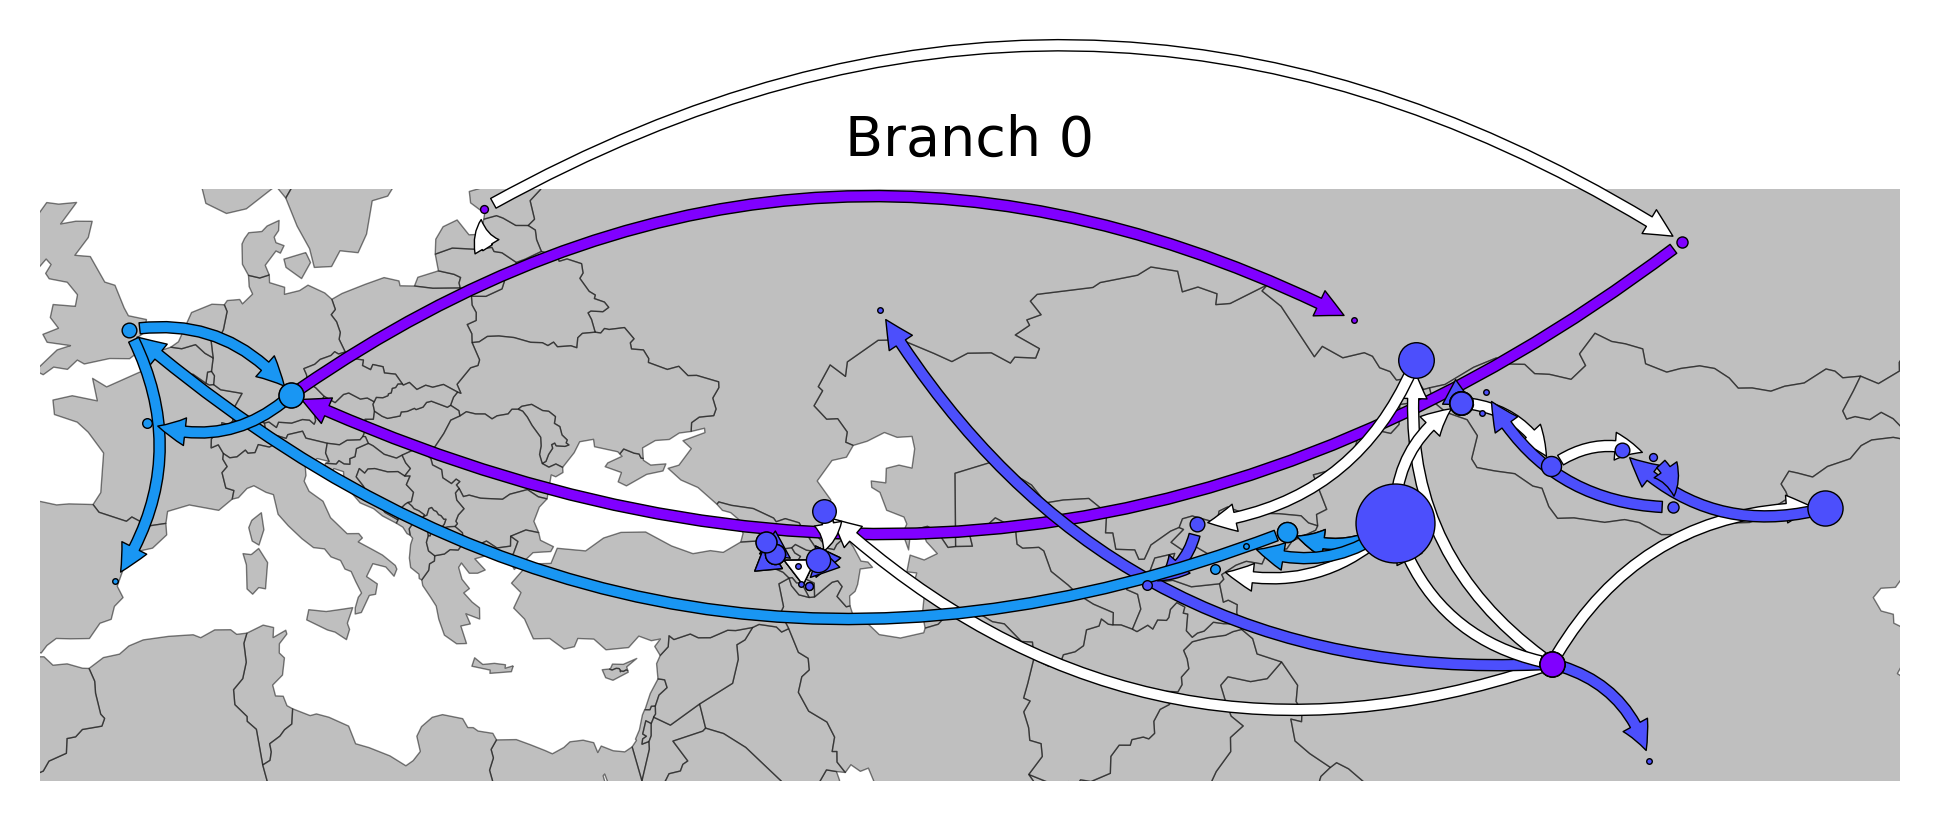

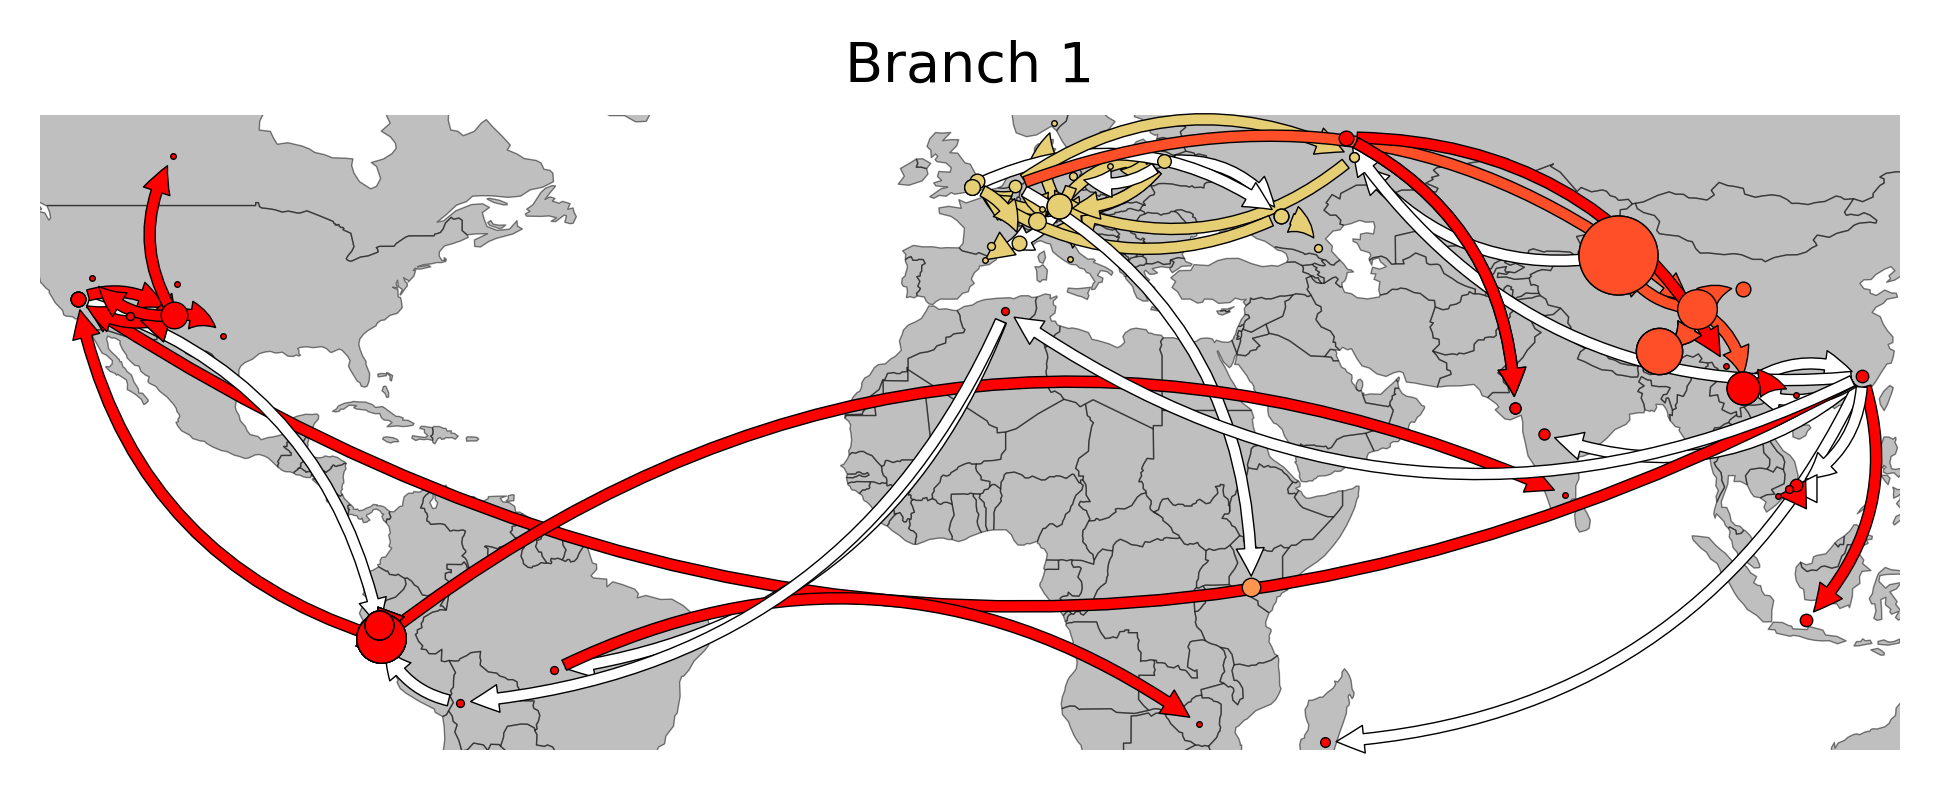

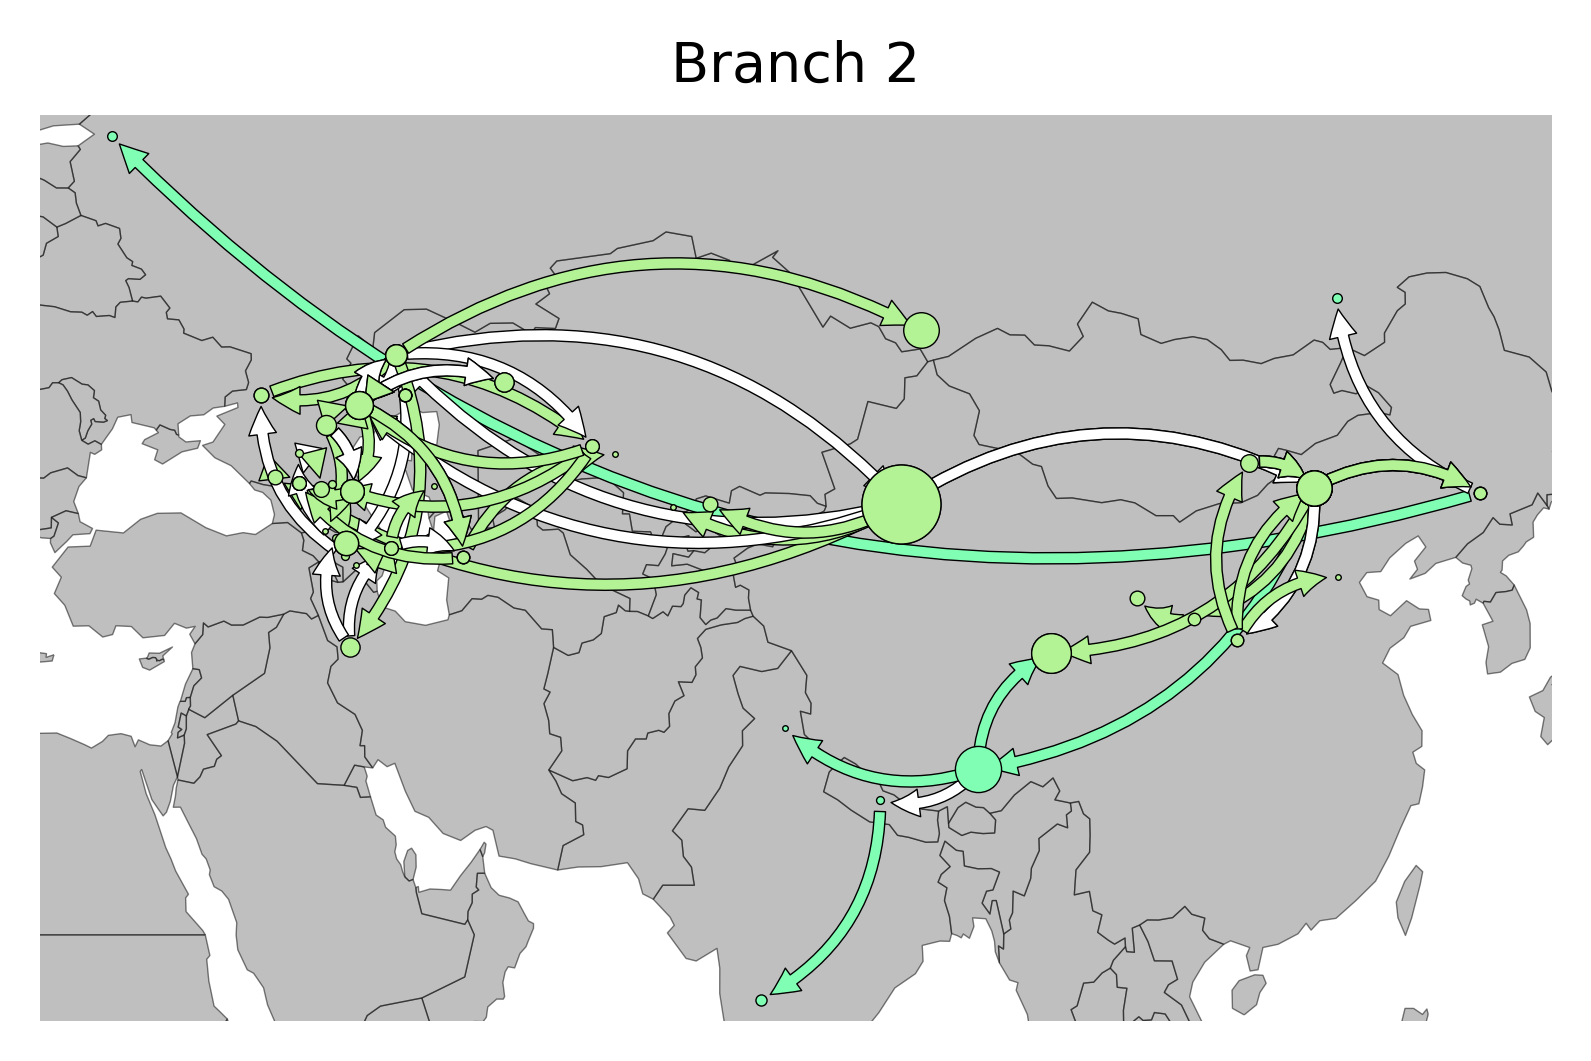

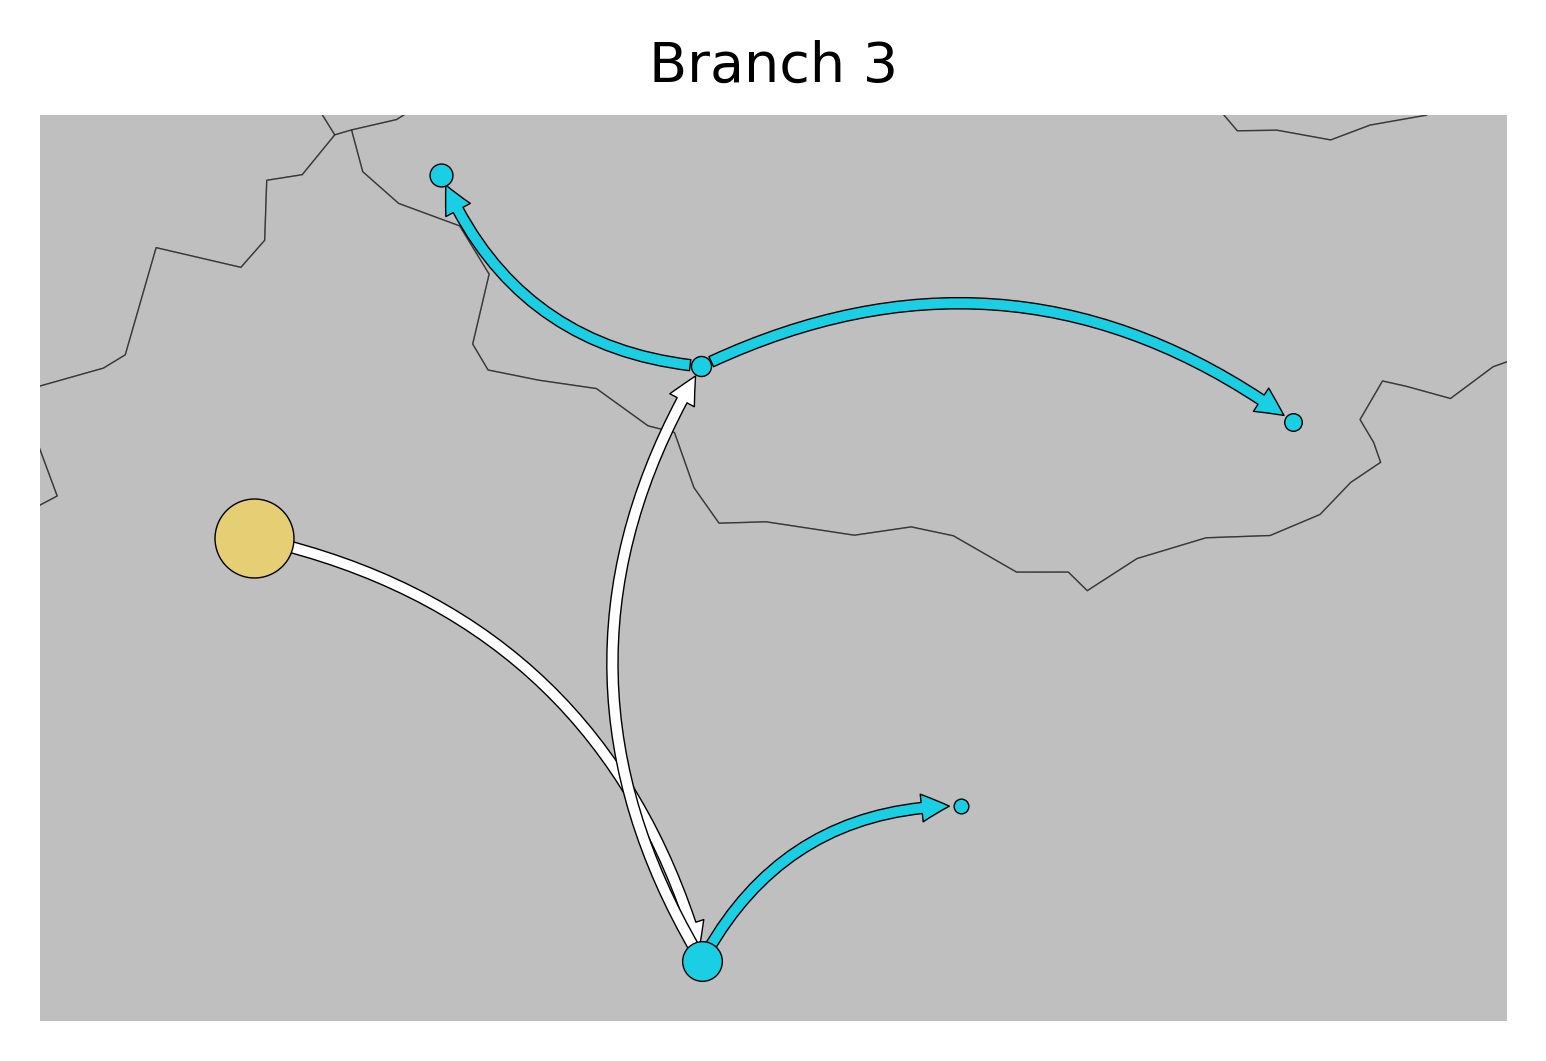

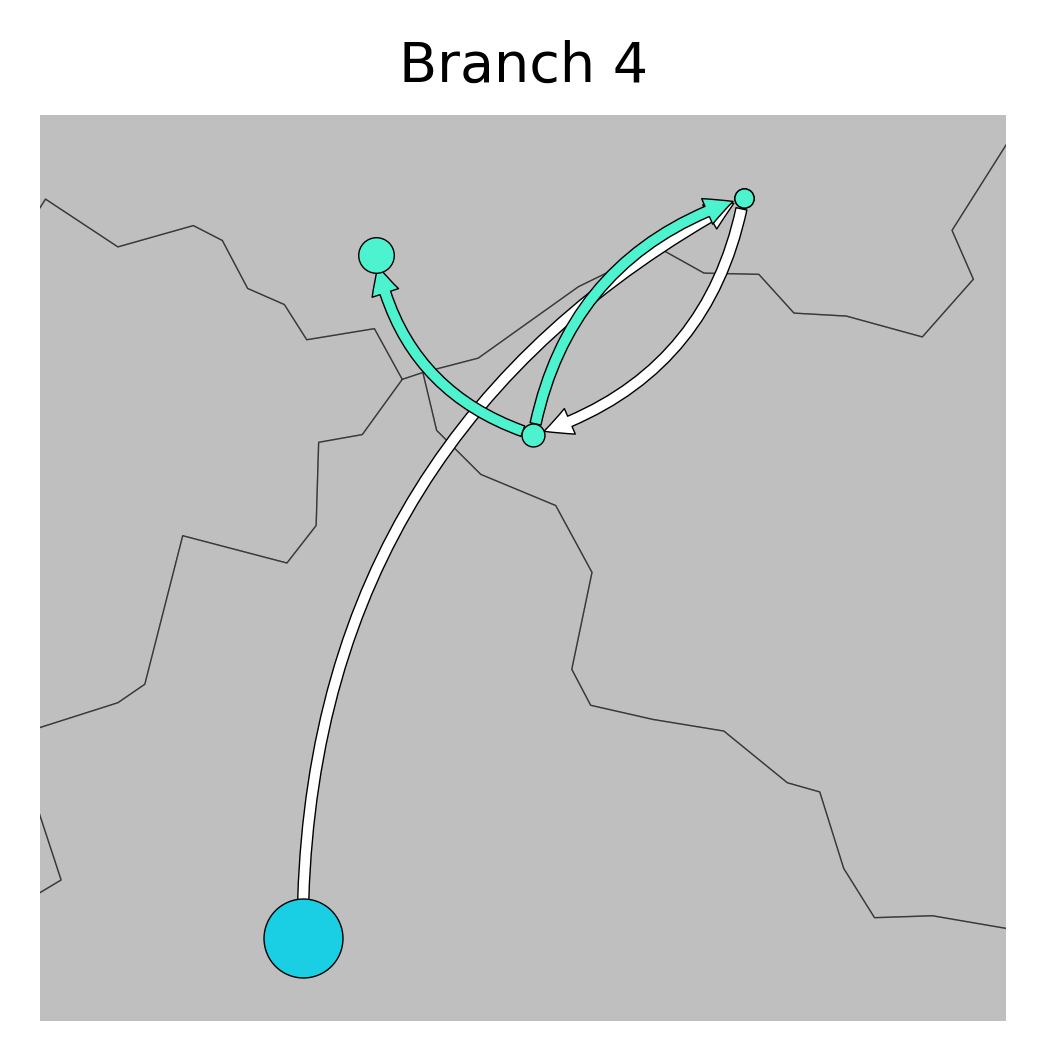

In [258]:
for branch in branch_dict:
    #if branch != "3": continue
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=(6,3))
    # --------------------------------------
    # World Basemap
    world_poly = world_polygons.plot(ax=ax1, 
                        zorder=1, 
                        alpha=0.5, 
                        color="grey",
                        edgecolor="black", 
                        linewidth=0.25,
                       )
    
    gdf = branch_dict[branch]["gdf"]
    tree = branch_dict[branch]["clade"]
    

    # Store node connections
    connect_list = []
    
    for t in tree.get_terminals():
        # Check for an upper node
        if tree.up:
            path = tree.up.get_path(t)
        else:
            path = tree.get_path(t)
        for i in range(0, len(path) -1):
            connection = [path[i].name, path[i+1].name]
            # Don't store duplicate connections
            if connection not in connect_list:
                connect_list.append(connection)

    # Plot root location
    root_gdf = gdf[gdf.index.str.contains(tree.root.name)]
    state = root_gdf["Mugration_Branch_Major"].values[0]
    geom = root_gdf["geometry"].values[0]
    root_gdf.plot(ax=ax1, 
                  color = colors_dict["branch_major"][state],
                  markersize = sizes_dict[str(geom)],
                  edgecolor = "black",
                  linewidths=0.25,  
                  zorder=2,
                  alpha=1,
                  )
    
    # Plot connections
    for connection in connect_list:
        origin = gdf[gdf.index.str.contains(connection[0])]
        dest = gdf[gdf.index.str.contains(connection[1])]
        origin_geom = origin["geometry"].values[0]
        dest_geom = dest["geometry"].values[0]
        dest_state = dest["Mugration_Branch_Major"].values[0]
        dest_color = colors_dict["branch_major"][dest_state]
        arrow_color = "white"
        dest_confidence = dest["Mugration_Province_Confidence"].values[0]
        if dest_confidence >= MUG_CONF_THRESH:
            arrow_color = dest_color
        # check if we're changing locations
        if origin_geom != dest_geom:
            # Plot the destination point
            dest.plot(ax=ax1, 
                  color = dest_color,
                  markersize = sizes_dict[str(dest_geom)],
                  edgecolor = "black",
                  linewidths=0.25,    
                  zorder=2,
                  )
            # Plot the connection arrow
            ax1.annotate('', xy=(dest_geom.x, dest_geom.y), xytext=(origin_geom.x, origin_geom.y),
                xycoords='data',
                size=10,
                zorder=1,
                arrowprops=dict(facecolor=arrow_color, 
                                ec = 'black', 
                                lw=0.25,
                                arrowstyle="simple",
                                connectionstyle="arc3,rad=-0.3"))

    # --------------------------------------
    # Limits
    
    # Get xlim from data
    x_min = 300
    x_max = -300
    y_min = 100
    y_max = -100
    range_x_min = 40
    for geom in branch_dict[branch]["gdf"]["geometry"]:
        if geom.x <= x_min:
            x_min = geom.x
        elif geom.x > x_max:
            x_max = geom.x
        if geom.y <= y_min:
            y_min = geom.y
        elif geom.y > y_max:
            y_max = geom.y
            
    x_buffer = 5
    y_buffer = 1
    ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax1.set_ylim(y_min - y_buffer, y_max + y_buffer)
    
    ax1.set_title("Branch {}".format(branch))

    # --------------------------------------
    # Labels
    ax1.axis('off')
    
    # ---
    # Legend
    #arrow = plt.arrow(0, 0, 0.5, 0.6, fc="white", ec="black", linewidth=0.25)
    #plt.legend([arrow,], ['<95% Confidence',], fontsize=4)
        
    out_path = os.path.join(outdir, SCRIPT_NAME + "_spreadmap_{}.{}".format(branch, FMT)) 
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")
    out_path = os.path.join(outdir, SCRIPT_NAME + "_spreadmap_{}.{}".format(branch, ".png")) 
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 2. Objective 2

---
# Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [ ]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Divtrees

In [ ]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")